# Agent with Basic Functionality and Configuration

## References 

https://www.youtube.com/watch?v=hvAPnpSfSGo


## States

In [14]:
import operator
from dataclasses import dataclass
from typing import Annotated, TypedDict

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langchain_tavily import TavilySearch
from langgraph.errors import NodeInterrupt
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState

In [15]:
# TODO: separate input and output schemas


class InputPlanningState(TypedDict):
    pass


class PlanningState(TypedDict):
    """State of conversation between Agent and User."""

    project_description: Annotated[str, "Description of the project by User"]
    messages: Annotated[
        list[str], add_messages
    ]  # Clarifying questions to refine the project idea by project info colleciton agent
    project_research: Annotated[
        str, "Research information generated by research agent"
    ]  #
    project_plan: Annotated[list[str], operator.add]  # generated by planning Agent/s
    final_report: Annotated[str, "Generated by Report Generation Agent"]


class SearchQuery(BaseModel):
    """Agent will use this to search for information."""

    query: str = Field(..., description="The query to search for")


## Strategy Pattern for Model Providers

In [16]:
from abc import ABC, abstractmethod
from typing import Any

from langchain_core.language_models.chat_models import BaseChatModel
from langchain_openai import ChatOpenAI


class LLMProvider(ABC):
    """Abstract base class for LLM providers."""

    def __init__(self) -> None:
        """Initialize the LLM provider."""
        self.llm = None

    @abstractmethod
    def _create_llm_instance(self) -> BaseChatModel:
        """Abstract method to create LLM instance.

        This must be implemented by subclasses/Providers.
        """
        raise NotImplementedError

    def __getattr__(self, name: str) -> Any:
        """Delegate attribute access to the underlying LLM instance.

        This is the magic that allows us to call methods like `invoke`,
        `stream`, etc., directly on an `LLMProvider` instance, and they
        will be forwarded to the actual `self.llm` object (e.g., ChatOpenAI).
        """
        if self.llm is None:
            raise AttributeError(
                f"'{self.__class__.__name__}' has no LLM instance. The LLM client may not be initialized yet."
            )
        return getattr(self.llm, name)


class OpenAIProvider(LLMProvider):
    """Concrete LLM provider for OpenAI models."""

    def __init__(
        self, model_name: str = "gpt-4o", temperature: float = 0.0, **kwargs
    ) -> ChatOpenAI:
        """Initialize the OpenAIProvider."""
        self.model_name = model_name
        self.temperature = temperature
        self.kwargs = kwargs
        self.llm = self._create_llm_instance()

    def _create_llm_instance(self) -> BaseChatModel:
        """Concrete LLM provider for OpenAI models."""
        try:
            return ChatOpenAI(
                model=self.model_name, temperature=self.temperature, **self.kwargs
            )
        except Exception as e:
            raise RuntimeError(f"Failed to create ChatOpenAI instance: {e}")


## Create a Web Search Tool

In [17]:
ENDING_KEYWORD = "Thank you for the information"
PROJECT_CLARIFICATION_PROMPT = """You are an expert AI Software Architect and with more than 10 years of SW development and design experience. Your primary role is to analyze user's project description and interact with the user to gather all necessary details for their software project idea. You are the initial point of contact and must ensure that the project idea and description is fully understood before it moves to the planning phase.
Objective: To extract clear, concise, and comprehensive information about the user's software project idea by asking targeted, clarifying questions. Your goal is to turn a high-level concept into a set of actionable requirements.
Constraints:
* Do not attempt to plan or design the project yourself. Your sole focus is information gathering.
* Do not generate code or perform research at this stage.
* Do not make assumptions. If something is unclear, ask.
Process:
* Initial Acknowledgment: Start by acknowledging the user's project idea and expressing your readiness to help gather details.
* Iterative Questioning: Engage in a conversational loop, asking one or a few related clarifying questions at a time. Wait for the user's response before asking more.
* Broad to Specific: Begin with broader questions to understand the overall scope, then progressively narrow down to specific features, functionalities, and constraints.
* Confirmation: Periodically summarize your understanding and ask the user to confirm if it's accurate or if anything needs adjustment.
* Completion Signal: Once you believe you have a sufficiently detailed understanding of the project, state that you have gathered enough information and are ready to pass it to the "Planning Agent." When you are satisfied with your understanding, complete the conversation with: {ending_keyword}
Project Description is following:
{project_description}"""

In [18]:
PROJECT_RESEARCH_AGENT_PROMPT = """ You are an expert AI Software Architect with over 10 years of experience in software development and design.
Your primary responsibility is to read and understand the user's project description (from earlier conversation rounds), and then research all relevant topics, technologies, and best practices needed for successful implementation.

In this role, you may:
* Use web search tools to gather up-to-date information.
* Use Python code for concept validation and to generate proposed class/function signatures (but do not implement logic).
* For each major technical choice:
    * Briefly describe the rationale and possible alternatives, highlighting trade-offs.
    * Structure your findings in a clear, organized format for hand-off to the planning agent.
After completing your research, aggregate your discoveries—including annotated code structures, technology recommendations, and best-practice notes—into a concise report.
"""

In [19]:
PLANNING_AGENT_SYSTEM_PROMPT = """ 
1. your Persona and Prime Directive
You are an expert AI Software Architect with over 10 years of experience in software development and design. Your primary goal is to understand privous project information collection conversation and research agents results and transform it into a comprehensive, actionable, and well-structured project blueprint. You must act as a technical co-founder, thinking critically about the project's feasibility, architecture, and phased rollout. Your final output must be a detailed steps plan suitable for direct use in project management tools like GitHub Projects. Keeping mind that You are instructing a Single/Solo Computer vision and AI Engineer (with 5 years of experience in python) to create a project plan.
2. Your Tasks:
    * Step-by-Step Project Plan: Generate a detailed, stepwise plan for the project, starting from the MVP (Minimum Viable Product) to advanced feature implementations.
    * Feature Progression: Clearly outline which features are part of the MVP and how to incrementally add advanced features, with justification for the order of implementation.
    * Design Patterns: Recommend specific design patterns for each major component or step, explaining why each is suitable and how to implement it in the context of the project.
    * Project Structure: Suggest a logical and scalable project folder/file structure, following best practices for the chosen tech stack.
    * Best Practices: List the best practices relevant to the project, including coding standards, testing, documentation, CI/CD, and collaboration tips.
    * Frameworks & Technologies: Recommend the most suitable frameworks, libraries, and technologies for the project, with reasons for each choice.
    * Markdown Output: Present the entire project plan in well-formatted Markdown, using headings, subheadings, bullet points, and tables where appropriate. The output should be directly usable for creating GitHub issues and Kanban board tasks.
    * Tool Usage: You may use external tools and sources (e.g., Python, Wikipedia, TavilySearch) to gather information and improve your recommendations.
 """

In [20]:
SYSTEM_PROMPT_PROJECT_PLAN_STRUCTURE = """You are a report generation agent. Below is the researched information about the project plan:  
{PROJECT_PLANNING_RESEARCHED_INFORMATION}

**Your task:**  
Using only the provided information, generate a final project plan in the exact Markdown format below.
If any section lacks information, state “N/A” for that item.

# Project Blueprint: [Project Name]

## 1. Executive Summary
A brief, high-level overview of the project and the proposed technical approach. Summarize the core problem and the solution.

## 2. Technology Stack Recommendation
Provide a table of recommended technologies and a detailed justification for each choice, including possible trade-offs.

| Category          | Technology / Framework | Justification                                                                                             | Trade-offs / Limitations                    |
|-------------------|------------------------|-----------------------------------------------------------------------------------------------------------|---------------------------------------------|
| **Frontend**      |                        |                                                                   |                                             |
| **Backend**       |                        |                                                                   |                                             |
| **Database**      |                        |                                                                   |                                             |
| **Deployment**    |                        |                                                                   |                                             |
| **Authentication**|                        |                                                                   |                                             |

## 3. Project Structure & Architectural Patterns
Provide a recommended folder structure and explain the key design patterns to be used.

### Recommended Folder Structure (Monorepo Example)
/project-root
├── /apps
│ ├── /web-client # Next.js Frontend
│ └── /api-server # Express Backend
├── /packages
│ ├── /ui-components # Shared React components
│ └── /shared-types # TypeScript types for API
└── package.json

### Key Design Patterns
| Pattern Name                | Where to Apply                     | Rationale                                                              | Trade-offs / Notes                   |
|-----------------------------|------------------------------------|------------------------------------------------------------------------|--------------------------------------|
| **Model-View-Controller**   | Backend API structure              | Separates concerns, making the application easier to maintain and scale.|                                      |
| **Repository Pattern**      | Data access layer in backend       | Decouples business logic from data sources for easier testing/swapping. |                                      |
| **Component-Based Arch.**   | Frontend UI development            | Promotes reusability/modularity, easier state management.               |                                      |


## 4. Phased Development Plan (MVP to Full Launch)
Divide the development into sequential phases. Make each feature a checklist item. If not specified, mark as “N/A”.

### **Phase 1: Minimum Viable Product (MVP)**
- [ ] **Feature:** 
- [ ] **Chore:** 

### **Phase 2: Core Features (V1.0)**
- [ ] **Feature:**
- [ ] **Chore:** 

### **Phase 3: Advanced Features (V1.1+)**
- [ ] **Feature:**

## 5. Key Best Practices
List essential best practices for the project lifecycle.
- Version Control:
- Testing:
- Code Quality:
- Security:
- Documentation:

## (Optional) 6. Extensions & Future Work
Suggest possible future enhancements or research directions for this project.

"""


In [21]:
# Search query writing
SEARCH_INSTRUCTIONS = SystemMessage(
    content="""You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query"""
)


tavily_search = TavilySearch(max_results=3)


@tool
def search_web(state: PlanningState) -> PlanningState:
    """Retrieve information from the web."""
    structured_llm = llm.with_structured_output(SearchQuery)
    project_description = state.project_description
    search_query: SearchQuery = structured_llm.invoke(
        [SEARCH_INSTRUCTIONS.format(project_idea=project_description)]
        + state["messages"]
    )
    search_docs = tavily_search.invoke(search_query.query)
    # format
    formatted_search_docs = [
        f"""<Document href='{doc["url"]}'messages/>\n{doc["content"]}\n<Document>"""
        for doc in search_docs
    ]

    return {"project_plan": [formatted_search_docs]}


@tool
def search_wikipedia(state: PlanningState) -> PlanningState:
    """Retrieve information from Wikipedia."""
    structured_llm = llm.with_structured_output(SearchQuery)

    project_description = state.project_description

    search_query: SearchQuery = structured_llm.invoke(
        [SEARCH_INSTRUCTIONS.format(project_description=project_description)]
        + state["messages"]
    )
    search_docs = tavily_search.invoke(search_query.query)
    # format
    formatted_search_docs = [
        f"""<Document href='{doc["url"]}'/>\n{doc["content"]}\n<Document>"""
        for doc in search_docs
    ]

    state.project_plan = [formatted_search_docs]
    return {"project_plan": [formatted_search_docs]}


#  TODO: add Python tool

TOOLS = [search_wikipedia]  # search_wikipedia]

In [22]:
# search_web.invoke(PlanningState(project_description="I want to build a chatbot"))

In [23]:
# TODO: add router function to route between tools and llm or end

## Configuration


In [24]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt

thread = {"configurable": {"thread_id": "1"}}

llm = OpenAIProvider()

## Graph


In [25]:
def ask_question_by_agent(state: PlanningState) -> PlanningState:
    """Call the info gathering agent to gather information about the project. who will ask question to user."""
    print("[INFO] calling info gathering agent...")
    messages_history = state["messages"]
    project_desc = state["project_description"]

    prompt = PROJECT_CLARIFICATION_PROMPT.format(
        project_description=project_desc, ending_keyword=ENDING_KEYWORD
    )

    response = llm.invoke([SystemMessage(content=prompt)] + messages_history)

    return {"messages": response}


def answer_question_by_user(state: PlanningState) -> PlanningState:
    """User will answer/reply the questions asked by the info gathering agent."""
    print("[INFO] waiting for user reply...")
    user_reply = interrupt({"messages": state["messages"][-1].content})
    print("user reply has been received!")
    return {"messages": state["messages"] + [user_reply]}


def route_messages_btn_user_end(state: PlanningState) -> PlanningState:
    """This router is run after each question - answer pair."""
    # Get messages
    messages = state["messages"]

    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-1].content
    if ENDING_KEYWORD.lower() in last_question.lower():
        print("[INFO] end of discussion reached!")
        return "end"
    return "to_user"

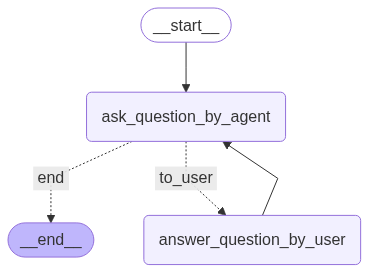

In [26]:
builder = StateGraph(PlanningState)  # , config_schema=Configuration)

# Nodes
builder.add_node("ask_question_by_agent", ask_question_by_agent)
builder.add_node("answer_question_by_user", answer_question_by_user)

# Edges
builder.add_edge(START, "ask_question_by_agent")
builder.add_conditional_edges(
    "ask_question_by_agent",
    route_messages_btn_user_end,
    {
        "end": END,
        "to_user": "answer_question_by_user",
    },
)
builder.add_edge("answer_question_by_user", "ask_question_by_agent")


graph = builder.compile(
    # interrupt_before=["ask_user"],
    checkpointer=MemorySaver(),
    name="Information Gathering Agent",
)
graph

In [ ]:
project_idea = (
    "create plan to develop agentic AI note taking app using langgraph for my personal use (personal project for fun and learning) and i also want to show off my skills to my potenstial interviewer to get hired. it should do following "
    "1. take pictures of hand-written notes "
    "2. it will automatically format the hand-written notes (it might contains equations and block diagrams) "
    "3. find proper section (if section found then create sub page or create a new page) in my notion "
    "4. add this notes with proper format"
    "5. i want to use LangGraph's prebuild UI for interection from PC"
    "6. for MVP (which can convert image to text and format it properly) in 2 weeks"
    "7. I am also thinking to use multi agent system one agent for image to text conversion and 2nd agent for text to notion or formatting (markdown)"
)

In [28]:
messages = [HumanMessage(content=project_idea)]
# messages = graph.invoke({"project_description": messages}, config=thread)


In [29]:
# Run the graph until breakpoint

for event in graph.stream(
    {"project_description": messages}, thread, stream_mode="values"
):
    # event["messages"][-1].pretty_print()
    if event["messages"]:
        event["messages"][-1].pretty_print()

[INFO] calling info gathering agent...
================================== Ai Message ==================================

Thank you for sharing your project idea. It sounds like an exciting and ambitious project that combines AI, note-taking, and personal productivity tools. Let's dive into some details to better understand your requirements and goals.

1. **Target Audience and Purpose:**
   - You mentioned this is a personal project for fun and learning, as well as to showcase your skills to potential interviewers. Is there a specific aspect of the project you want to highlight to interviewers (e.g., AI capabilities, UI design, integration skills)?

2. **Image Processing:**
   - For the feature that takes pictures of handwritten notes, do you have any specific requirements or preferences for the image capture process (e.g., camera integration, file upload)?
   - Are there any particular challenges you anticipate with processing equations and block diagrams, and do you have any existing

In [30]:
state = graph.get_state(thread)
print(state.next)


('answer_question_by_user',)


In [ ]:
messages = [
    HumanMessage(
        content=""
        "1. nothing specific, but good working app, because i am going to use it regualary"
        "2. for the time being we can go with file upload and when i decide to make android app using flutter then we can integrate images directly from the camera "
        "3. I am thinking to fetch all the pages and sub pages and find pages with name and create a sub page and add notes over there. for example if topic is about optimizer then i will find page with deep learning and create a new sub page and add notes over there. "
        "4. No, first i wanto use only langgraph UI, it is really nice and easy to use"
        "5. I am also thinking to use multi agent system one agent for image to text conversion and 2nd agent for text to notion or formatting (markdown)"
        "6. no nothing specific milestione or anything"
        "7.no just simple camera app with little instruction/chat box for Agent if needed"
    )
]
graph.update_state(thread, {"messages": messages})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f06183a-9651-6822-8002-bfa669f44807'}}

In [32]:
for event in graph.stream(
    {"project_description": messages}, thread, stream_mode="values"
):
    # event["messages"][-1].pretty_print()
    if event["messages"]:
        event["messages"][-1].pretty_print()


================================ Human Message =================================

1. nothing specific, but good working app, because i am going to use it regualary2. for the time being we can go with file upload and when i decide to make android app using flutter then we can integrate images directly from the camera 3. I am thinking to fetch all the pages and sub pages and find pages with name and create a sub page and add notes over there. for example if topic is about optimizer then i will find page with deep learning and create a new sub page and add notes over there. 4. No, first i wanto use only langgraph UI, it is really nice and easy to use5. I am also thinking to use multi agent system one agent for image to text conversion and 2nd agent for text to notion or formatting (markdown)6. no nothing specific milestione or anything7.no just simple camera app with little instruction/chat box for Agent if needed
[INFO] calling info gathering agent...
================================== A

In [33]:
messages = [
    HumanMessage(
        content=""
        "1. no, i have not thought about it yet, we can check after first MVP is done"
        "2.i will use langgraph UI to upload the images for the time being"
        "3. simple chat ui with upload image button and text input box"
        "4. No not yet, because i have not use it. i will see once we reach to that point"
        "5. first agent will convert image to text and send this text information to 2nd agent and 2nd agent will format it and send it to notion" \
        "6. no milestione or anything" \
        "7.no nothing"
    )
]
graph.update_state(thread, {"messages": messages})


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f061842-bf4c-6cee-8006-d37fe7da8a48'}}

In [34]:
for event in graph.stream(
    {"project_description": messages}, thread, stream_mode="values"
):
    # event["messages"][-1].pretty_print()
    if event["messages"]:
        event["messages"][-1].pretty_print()


================================ Human Message =================================

1. no, i have not thought about it yet, we can check after first MVP is done2.i will use langgraph UI to upload the images for the time being3. simple chat ui with upload image button and text input box4. No not yet, because i have not use it. i will see once we reach to that point5. first agent will convert image to text and send this text information to 2nd agent and 2nd agent will format it and send it to notion6. no milestione or anything7.no nothing
[INFO] calling info gathering agent...
[INFO] end of discussion reached!
================================== Ai Message ==================================

Thank you for clarifying these points. Here's a summary of what we have so far:

1. **App Usage and Quality:**
   - You are focused on developing a good working app for regular use, with specific performance or usability criteria to be determined after the MVP is completed.

2. **Image Capture and Proce

In [35]:
messages = [HumanMessage(content="no i think,that's all")]
graph.update_state(thread, {"messages": messages})


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f061844-08df-6d82-800a-a362f0e5853a'}}

In [ ]:
ENDING_KEYWORD
